In [79]:
import sys
sys.path.append("/home/diego/python/spike-train/") 
# # sys.path.append("/home/diego/Dropbox/hold_noise/pycharm_project/classes/")
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")
sys.path.append("/home/diego/python/generative-glm/") 
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pickle

from sptr.sptr import SpikeTrain
from icglm.models.glm import GLM
from icglm.iclamp import IClamp
from icglm.kernels.fun import KernelFun
from icglm.kernels.rect import KernelRect

%load_ext autoreload
%autoreload 2
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# df = pd.read_csv('/home/diego/Dropbox/hold_noise/dataframes/HNtrials.csv', index_col=0, dtype=str)
# df.loc['18815053']

In [81]:
# ker1, ker2 = KernelRect.kistler_kernels(2, 1)
# st_te.dot(st_te, ker1, ker2)
# st_te.dot(st_fr, ker1, ker2), st_fr.dot(st_te, ker1, ker2)
# st_fr.dot_product_matrix(st_fr, ker1, ker2)

35.55555555555556 0.44726562499999983
Starting gradient ascent... 

 Iteration 126 of 200 | Elapsed time: 4.88 seconds | log_prior=nan | log_posterior=-987.25
 
 Iteration 126 of 200 | Converged | Elapsed time: 0.0813 minutes | Log posterior is monotonic 

36.0 0.2932098765432097


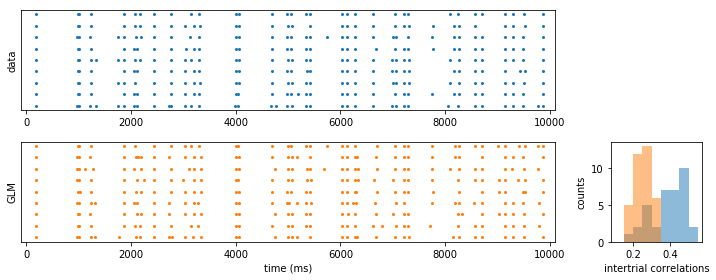

In [58]:
root_folder = '/home/diego/Dropbox/hold_noise/data/'

df = pd.read_csv('/home/diego/Dropbox/hold_noise/dataframes/HNtrials.csv', index_col=0, dtype=str)
# df = pd.read_csv('/home/diego/Dropbox/hold_noise/dataframes/HNlong.csv', index_col=0, dtype=str)
# df = df[df.age == 'm']

# filename = df.index[2]
# filename = '18815053'
filename = '18815005'
neuron = df.loc[filename, 'neuron']
ic = IClamp.load_from_abf(root_folder + neuron + '/' + filename + '.abf')

ic = ic.restrict(t0=1000.1, tf=11000.1, reset_time=True)
dt_subsample = 1
ic = ic.set_mask_spikes(thr=-13, t_before_spike_peak=0, use_derivative=False).subsample(dt_subsample, average_stim=True)

t = ic.t.copy()
stim = ic.stim.copy()
mask_spikes_te = ic.mask_spikes.copy()

st_te = SpikeTrain(t, mask_spikes_te)

kernel1, kernel2 = KernelRect.kistler_kernels(2, dt_subsample)
rel_true = st_te.reliability(kernel1, kernel2)
conv_te = st_te.convolve(kernel1)
# mean_te, var_te = np.mean(conv_te, 1), np.var(conv_te, 1)
print(np.mean(np.sum(mask_spikes_te, 0)), rel_true)

tbins_kappa = np.arange(0, 360, 8)
tbins_eta = np.arange(0, 450 + 25, 25)

glm = GLM(u0=5, kappa=KernelRect(tbins_kappa, 1e-2 * np.exp(-tbins_kappa[:-1] / 20)), 
         eta=KernelRect(tbins_eta, 7 * np.exp(-tbins_eta[:-1] / 20)))
glm.fit(t, stim, mask_spikes_te, verbose=True)
u_te, r_te = glm.simulate_subthreshold(t, stim, mask_spikes_te)

stim_samples = np.stack([np.mean(stim, 1)] * 9, 1)
u_fr, r_fr, mask_spikes_fr = glm.sample(t, stim_samples)
st_fr = SpikeTrain(t, mask_spikes_fr)
conv_fr = st_fr.convolve(kernel1)
mean_fr, var_fr = np.mean(conv_fr, 1), np.var(conv_fr, 1)
print(np.mean(np.sum(mask_spikes_fr, 0)), st_fr.reliability(kernel1, kernel2))

ker1 = ker2 = KernelFun.gaussian_delta(1)
cosine_te = st_te.cosine_matrix(st_te, ker1, ker2)[np.triu_indices(9, k=1)]
cosine_fr = st_fr.cosine_matrix(st_fr, ker1, ker2)[np.triu_indices(9, k=1)]

r1, r2 = 8, 2
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, r1 + r2), (0, 0), colspan=r1)
ax2 = plt.subplot2grid((2, r1 + r2), (1, 0), colspan=r1, sharex=ax1)
# ax3 = plt.subplot2grid((2, r1 + r2), (0, r1), colspan=r2)
ax4 = plt.subplot2grid((2, r1 + r2), (1, r1), colspan=r2)
# ti = np.arange(0, 100, .1)
# eta_vals = glm_fit.eta.interpolate(ti)
# ax3.plot(ti, np.exp(-eta_vals))
# ax3.set_title('post-spike filter')
# glm_fit.eta.plot(ax=ax3, exp_values=True)
st_te.plot(ax=ax1, ms=2)
st_fr.plot(ax=ax2, ms=2, color='C1')
ax1.set_yticks([])
ax2.set_yticks([])
ax2.set_xlabel('time (ms)')
ax1.set_ylabel('data')
ax2.set_ylabel('GLM')

# ax3.set_ylabel('gain')
# ax3.set_xlabel('time (ms)')
bins = np.arange(0.1, 0.6, .05)
ax4.hist(cosine_te, alpha=0.5, bins=bins)
ax4.hist(cosine_fr, alpha=0.5, bins=bins)
ax4.set_xlabel('intertrial correlations')
# # ax4.set_ylabel('p(# spikes)'); ax4.set_ylim(0, 0.04)
ax4.set_ylabel('counts')
fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/reliability_fail.pdf', bbox_inches='tight', transparent=True)

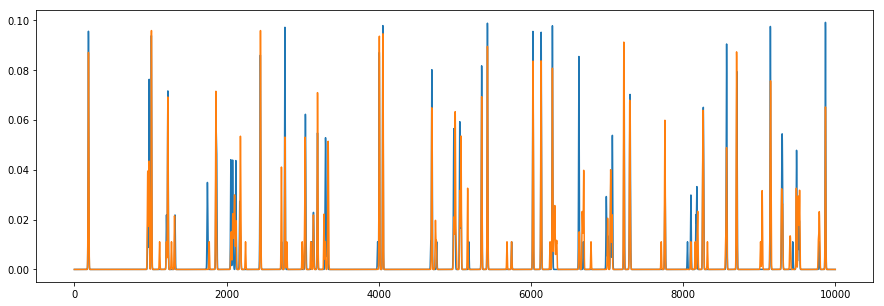

In [75]:
ker = KernelFun.gaussian_delta(4)
mean = np.mean(st_te.convolve(ker), 1)
mean2 = np.mean(st_fr.convolve(ker), 1)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(mean)
ax.plot(mean2)

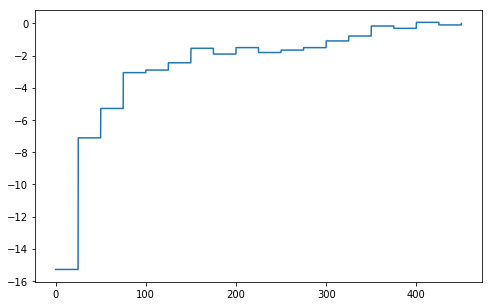

In [78]:
glm.eta.plot(invert_values=True)

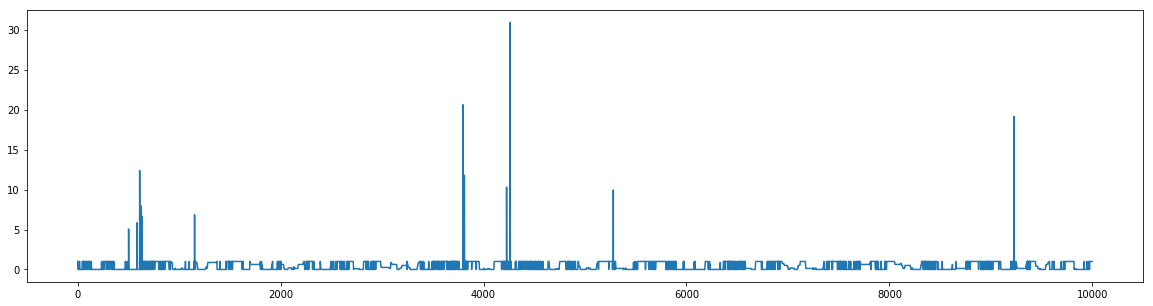

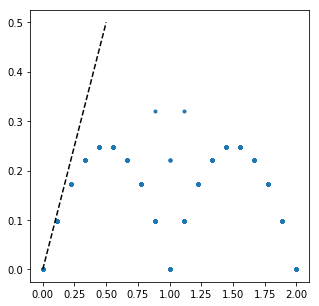

In [71]:
# ker = KernelFun.gaussian_delta(4)
ker = KernelRect([-50, 50], [1])
conv = st_te.convolve(ker)
mean = np.mean(conv, 1)
var = np.var(conv, 1)
fano = st_te.sliding_fano_factor(ker)
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(t, fano)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(mean, var, '.')
ax.plot([0, 0.5], [0, 0.5], 'k--')

In [48]:
np.min(np.concatenate((cosine_te, cosine_fr))), np.max(np.concatenate((cosine_te, cosine_fr)))

(0.1270157218071671, 0.533873956625981)

In [16]:
delta = 2
ker = KernelRect(tbins=[-delta, delta + dt_subsample], coefs=[1])
np.mean(st_te.sliding_fano_factor(ker)), np.mean(st_fr.sliding_fano_factor(ker))

(0.4787375000000002, 0.5010000000000002)

136.55555555555554 0.20680367118914608


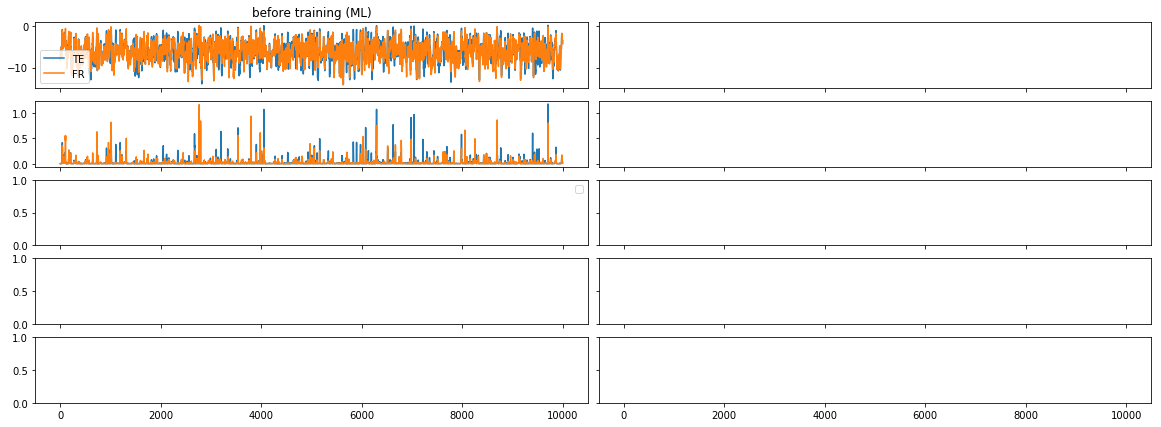

In [101]:
fig, ((ax00, ax01), (ax10, ax11), (ax20, ax21), (ax30, ax31), (ax40, ax41)) = plt.subplots(figsize=(20, 7), nrows=5, ncols=2, 
                                                                                           sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.02)

ax00.set_title('before training (ML)')
ax00.plot(t, u_te[:, 0], label='TE')
ax00.plot(t, u_fr[:, 0], label='FR')
ax00.legend()
ax10.plot(t, r_te[:, 0])
ax10.plot(t, r_fr[:, 0])
# ax20.plot(t, critic_conv_te[:, 0], label='critic TE')
# ax20.plot(t, critic_conv_fr[:, 0], label='critic FR')
# ax20.plot(t, (critic_conv_te * r_te)[:, 0])
# ax20.plot((critic_conv_fr * r_fr)[:, 0])
ax20.legend()

(array([152., 105.,  96., ...,   3.,   1.,   3.]),
 array([0.  , 0.01, 0.02, ..., 0.52, 0.53, 0.54]),
 <a list of 54 Patch objects>)

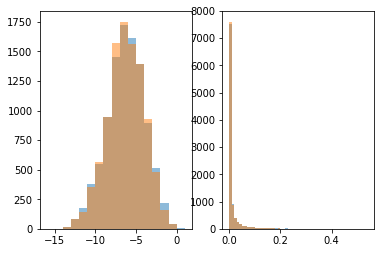

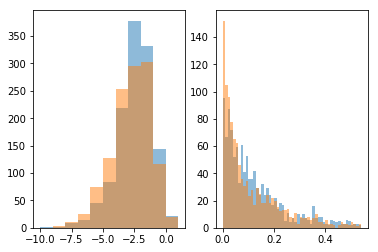

In [102]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.hist(u_te[:, 0], alpha=0.5, bins=np.arange(-16, 2, 1))
ax1.hist(u_fr[:, 0], alpha=0.5, bins=np.arange(-16, 2, 1))
ax2.hist(r_te[:, 0], alpha=0.5, bins=np.arange(0, 0.55, .01))
ax2.hist(r_fr[:, 0], alpha=0.5, bins=np.arange(0, 0.55, .01))

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.hist(u_te[mask_spikes_te], alpha=0.5, bins=np.arange(-10, 2, 1))
ax1.hist(u_fr[mask_spikes_fr], alpha=0.5, bins=np.arange(-10, 2, 1))
ax2.hist(r_te[mask_spikes_te], alpha=0.5, bins=np.arange(0, 0.55, .01))
ax2.hist(r_fr[mask_spikes_fr], alpha=0.5, bins=np.arange(0, 0.55, .01))

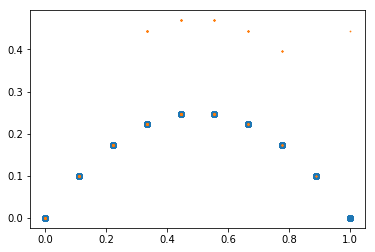

In [103]:
fig, ax = plt.subplots()
ax.plot(mean_te, var_te, 'o')
ax.plot(mean_fr, var_fr, '.', ms=1.5)